Performing Exploratory and data Preparation on the future house data

In [1]:
#---------------------------------------Introduction to Data Preparation--------------------------------------------------

Created by John Omole Email: contact@johnomole.de Website: www.johnomole.de

In [2]:
#------------------------------------Importing Libraries needed.------------------------------------#

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import catboost
from catboost import Pool
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import os

In [4]:
# importing libraries required for our model
import tensorflow as tf
from tensorflow.python import tf2
if not tf2.enabled():
    import tensorflow.compat.v2 as tf
    tf.enable_v2_behavior()
    assert tf2.enabled()

import tensorflow_probability as tfp
tfd = tfp.distributions
from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense,Dropout,Input,LSTM,Dropout
from tensorflow.keras.models import model_from_json
from tensorflow.keras.layers import Flatten
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras import regularizers
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import TensorBoard

In [5]:
#------------------------------------Data Preparation.------------------------------------#

In [28]:
df = pd.read_csv('meterusage/meterusage.csv', index_col = 0)

In [29]:
#Check for the first 5 data in the file
print('Meterusage Data')
display(df.head())

#stastical analysis of the training data
print('Meterusage Data Descriptive Statistic')
display(df.describe())

Meterusage Data


,meterusage
time,
2019-01-01 00:15:00,55.09
2019-01-01 00:30:00,54.64
2019-01-01 00:45:00,55.18
2019-01-01 01:00:00,56.03
2019-01-01 01:15:00,55.77


Meterusage Data Descriptive Statistic


,meterusage
count,2974.000000
mean,143.091342
std,92.549512
min,45.600000
25%,55.682500
50%,117.615000
75%,253.057500
max,355.440000


In [30]:
#------------------------------------Data Cleaning.------------------------------------#

In [31]:
#  Checking for nan or empty number in the training data
print('Meterusage')
display(df.isnull().sum())

Meterusage


meterusage    1
dtype: int64

In [36]:
df.dropna(inplace = True)

In [37]:
print('Meterusage rows: ', df.shape[0])
print('Meterusage columns: ', df.shape[1])

Meterusage rows:  2974
Meterusage columns:  1


In [ ]:
#Removing outliers

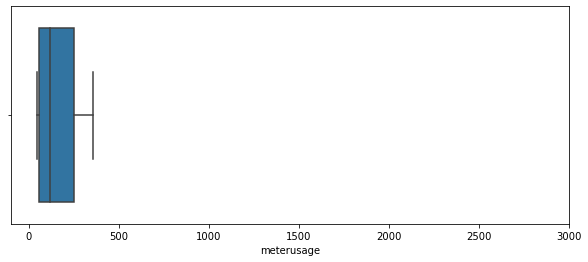

In [38]:
#Visualising outliers
plt.figure(figsize=(10,4))
plt.xlim(-100, 3000)
flierprops = dict(marker='o', markerfacecolor='purple', markersize=6,
                  linestyle='none', markeredgecolor='black')
sns.boxplot(x=df.meterusage, flierprops=flierprops)

In [34]:
#Dropping Ouliers
def drop_out(df,feature,high_percentile = .99):
    df_shape = df.shape[0]         #train df size before dropping
    max_val = df[feature].quantile(high_percentile)      #Percentile value
    print('Dropping Outliers for ... {}'.format(feature))
    df = df[df[feature] < max_val]
    print(str(df_shape - df.shape[0]) + ' ' + feature + ' values over ' + str(max_val) + ' have been removed' )
    return df

In [39]:
#Dropping outliers for item_price
df = drop_out(df,'meterusage')

Dropping Outliers for ... meterusage
30 meterusage values over 295.5054 have been removed


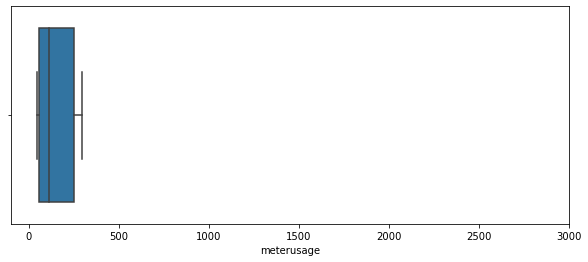

In [40]:
plt.figure(figsize=(10,4))
plt.xlim(-100, 3000)
flierprops = dict(marker='o', markerfacecolor='purple', markersize=6,
                  linestyle='none', markeredgecolor='black')
sns.boxplot(x=df.meterusage, flierprops=flierprops)

In [41]:
print('Meterusage')
display(df.head())

print('Shape')
display(df.shape)

print('Stats')
display(df.describe())

Meterusage


,meterusage
time,
2019-01-01 00:15:00,55.09
2019-01-01 00:30:00,54.64
2019-01-01 00:45:00,55.18
2019-01-01 01:00:00,56.03
2019-01-01 01:15:00,55.77


Shape


(2944, 1)

Stats


,meterusage
count,2944.000000
mean,141.457959
std,91.576480
min,45.600000
25%,55.645000
50%,113.545000
75%,250.505000
max,295.500000


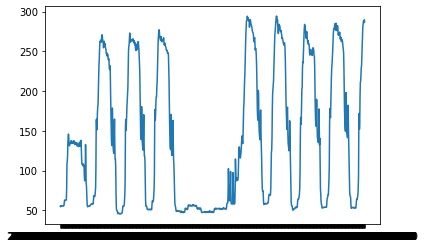

In [55]:
plt.plot(df[:1000])

([array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  array([1., 0., 0., 0., 0., 0.

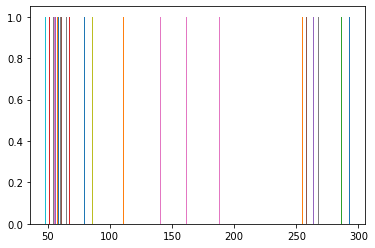

In [56]:
plt.hist(df)